<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# Image Captioning Model
In the realm of multi-modal large language models (MLLMs), image-to-text and text-to-image models are among one of the most commonly seen applications. Can we generate a caption given an image and vice versa? We saw in the presentation that transformer architectures are general sequence-processing architectures that can process both images and text. In this lesson, we will learn how to build a vision-text transformer architecture yourself and compare the DIY-transformer performance against a pre-trained image captioning model. 

### ![Dolly](https://files.training.databricks.com/images/llm/dolly_small.png) Learning Objectives
1. Connect pretrained vision and text models as a single transformer architecture for image captioning
1. Train your image captioning model
1. Qualitatively inspect the quality of the caption generated
1. Compare the output with an pretrained image captioning model

## Classroom Setup

In [ ]:
# MAGIC %run ../Includes/Classroom-Setup

We are going to use `sbu_captions` as our dataset to train our own image captioning model. 

`sbu_captions` contains 1 million pairs of image urls and captions. Visit [this link](https://huggingface.co/datasets/sbu_captions) to view their dataset on Hugging Face Datasets hub.

In [1]:
from datasets import load_dataset

data = load_dataset("sbu_captions", split="train").shuffle(seed=42)
data

Dataset({
    features: ['image_url', 'user_id', 'caption'],
    num_rows: 1000000
})

## Initialize an image-to-text model
In the following section, we are going to use [Vision Encoder Decoder Model](https://huggingface.co/docs/transformers/model_doc/vision-encoder-decoder) to initialize our image-to-text model. The encoder would be a transformer-based vision model to process the images and the decoder is a language model to generate the caption. Then, we will connect both the vision and language model together and further train the vision-language model on a subset of `sbu_captions`. 

### Define data processing function
First, we will need to have a function to properly process our training dataset that contains the image urls and respective captions.

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import requests
from io import BytesIO

class ProcessDataset(Dataset):
    def __init__(self, df, tokenizer,feature_extractor, decoder_max_length=20):
        self.df = df
        self.tokenizer = tokenizer # this is for language model 
        self.feature_extractor = feature_extractor # this is for vision model 
        self.decoder_max_length = decoder_max_length # this is for caption output

    def __len__(self):
        # this is necessary so that HuggingFace won't complain that the dataset doesn't have __len__ method 
        # when it starts training
        return len(self.df)

    def __getitem__(self, idx):
        # this is another method name that HuggingFace expects 
        # get file name + text 
        img_path = self.df["image_url"][idx]
        caption = self.df["caption"][idx]
        
        # process image 
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content))
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values

        # labels here refer to each token in the caption
        labels = self.tokenizer(caption, 
                                truncation=True,
                                padding="max_length", 
                                max_length=self.decoder_max_length).input_ids

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

### Initialize tokenizer and image feature extractor
Next, we will initialize our tokenizer to process text and feature extractor to process images respectively. After this, we are ready to pass our training dataset for processing.

In [3]:
from transformers import GPT2TokenizerFast, ViTFeatureExtractor

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", cache_dir="../datasets"+"/models")
# GPT2 doesn't have a pad token 
tokenizer.pad_token = tokenizer.eos_token

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k", cache_dir="../datasets"+"/models")

/Users/vmishra/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [4]:
train_dataset = ProcessDataset(df=data[:2000],
                               tokenizer=tokenizer,
                               feature_extractor=feature_extractor)

### Using VisionEncoderDecoder 
Here, we will finally use `VisionEncoderDecoder` to connect our pretrained image and text models of choice. 

You might see in the output that some weights of the GPT2 model are not initialized from the model checkpoint; from HuggingFace: `You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.` For the best performance, we should ideally fine-tune this decoder on our own dataset separately and load the fine-tuned decoder. However, for simplicity's sake, we are simply going to use the model as is, and fine-tune the image-captioning model as a whole. 

In [5]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained\
    (encoder_pretrained_model_name_or_path="google/vit-base-patch16-224-in21k", 
     decoder_pretrained_model_name_or_path="gpt2", 
     tie_encoder_decoder=True, cache_dir="../datasets"+"/models")

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.7.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.0.crossattention.c_attn.weight', 'h.8.crossattention.c_proj.weight', 'h.5.crossattention.c_proj.bias', 'h.7.crossattention.c_proj.bias', 'h.11.ln_cross_attn.weight', 'h.5.crossattention.c_proj.weight', 'h.8.crossattention.c_attn.bias', 'h.10.ln_cross_attn.bias', 'h.1.ln_cross_attn.bias', 'h.1.crossattention.c_attn.bias', 'h.4.crossattention.c_proj.bias', 'h.5.crossattention.q_attn.weight', 'h.11.crossattention.c_proj.bias', 'h.5.crossattention.q_attn.bias', 'h.3.crossattention.c_attn.weight', 'h.7.crossattention.q_attn.weight', 'h.2.crossattention.c_proj.weight', 'h.7.ln_cross_attn.weight', 'h.9.crossattention.q_attn.weight', 'h.10.crossattention.c_proj.weight', 'h.4.ln_cross_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.0.crossattention.q_attn.bias', 'h.11.crossattention.c_proj.weight', 'h.6.l

In [6]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.eos_token_id

# We will adjust several more model configuration settings here 
model.config.vocab_size = model.config.decoder.vocab_size
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3 # this determines a sequence of N words that cannot be repeated 
model.config.length_penalty = 2.0

# For decoder only 
model.decoder.num_beams = 4
model.decoder.max_length = 20 

## Train image-captioning model
Recall that you have seen `data_collator` in Module 2 before. 

As a refresher, data collators help us form batches of inputs to pass in to the model for training. Go [here](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#data-collator) for documentation.

In [7]:
from transformers import Trainer, TrainingArguments
from transformers import default_data_collator
import os

BATCH_SIZE = 16
TRAIN_EPOCHS = 20

output_directory = os.path.join("../workdir/", "captioning_outputs")

training_args = TrainingArguments(
    output_dir=output_directory,
    per_device_train_batch_size=BATCH_SIZE,
    do_train=True,
    num_train_epochs=TRAIN_EPOCHS, # number of passes to see the entire dataset 
    overwrite_output_dir=True,
    no_cuda=True, # Not using GPU
    dataloader_pin_memory=False # this specifies whether you want to pin memory in data loaders or not
)

trainer = Trainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=default_data_collator,
)

/Users/vmishra/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/training_args.py:1257: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


Note: You might notice that this cells triggers a whole new MLflow run. [MLflow](https://mlflow.org/docs/latest/index.html) is an open source tool that helps to manage end-to-end machine learning lifecycle, including experiment tracking, ML code packaging, and model deployment. You can read more about [LLM tracking here](https://mlflow.org/docs/latest/llm-tracking.html).

In [8]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=20, training_loss=2.388279342651367, metrics={'train_runtime': 155.4876, 'train_samples_per_second': 0.386, 'train_steps_per_second': 0.129, 'total_flos': 1.082783346720768e+16, 'train_loss': 2.388279342651367, 'epoch': 20.0})

## Generate caption from an image
Now, let's try generating caption from a randomly picked image below.

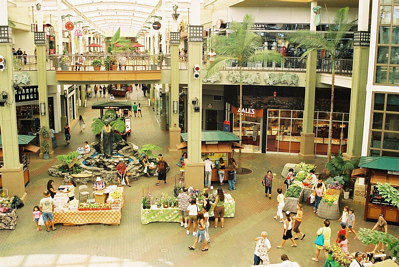

In [9]:
test_img = data[2021]

test_img_path = test_img["image_url"]
test_img_response = requests.get(test_img_path)
test_image = Image.open(BytesIO(test_img_response.content))
display(test_image)

In [10]:
caption = tokenizer.decode(trainer.model.generate(feature_extractor(test_image, return_tensors="pt").pixel_values)[0])
print("--"*20)
print(caption)

/Users/vmishra/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:399: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/Users/vmishra/miniconda3/envs/llm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `length_penalty` is set to `2.0` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `length_penalty`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/Users/vmishra/miniconda3

----------------------------------------
<|endoftext|>A man walks past a sign at the entrance to the park in the city of Napanee


Hmm, you can see that the caption is not really relevant to the image above. What went wrong? There are two possible reasons: 
- Parts of our text decoder weights were not loaded from the pretrained checkpoints. So the best approach would have been to train the decoder separately on the training dataset first and load the fine-tuned decoder. 
- Our image-captioning model needs more fine-tuning time! Try increasing the # of epochs, # of training data samples, and adjust other model hyperaparameters if you'd like. 

But now you learned how to plug in your own transformer-based models and connect them as an encoder-decoder model! It would definitely be much easier if we use an existing image captioning model instead. Let's do that next!  

## What if we use an existing image captioning model instead? 
Will the caption generated improve and be more relevant? Let's find out! 

We will be using a new model called `BLIP`, which stands for Bootstrapping Language-Image Pre-training. It's a modeling approach to unify vision-language understanding and generation by [Li et al 2022](https://arxiv.org/abs/2201.12086). It stands out from other vision-language model because: 

>  Most existing pre-trained models only excel in either understanding-based tasks or generation-based tasks. [...] BLIP effectively utilizes the noisy web data by bootstrapping the captions, where a captioner generates synthetic captions and a filter removes the noisy ones.

The excerpt above is from the paper's abstract. You can also read briefly about BLIP in the [HuggingFace documentation](https://huggingface.co/Salesforce/blip-image-captioning-base).

In [11]:
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base", cache_dir="../datasets"+"/models")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", cache_dir="../datasets"+"/models")

# conditional image captioning
# in many of the initial vision-language models, adding a prefix text like below "a photo of " is crucial for models to do well
# the addition of the prefix text makes the caption generation "conditional"
text = "a photo of"
inputs = blip_processor(test_image, text, return_tensors="pt")

conditional_output = blip_model.generate(**inputs)
print("Conditional output: ", blip_processor.decode(conditional_output[0], skip_special_tokens=True))

# unconditional image captioning
# in newer model iterations, researchers have found improvements to remove the need of adding a prefix text 
# therefore, the caption generation is "unconditional"
# notice that the `text` field is no longer filled out (it's now optional)
inputs = blip_processor(test_image, return_tensors="pt")

unconditional_output = blip_model.generate(**inputs)
print("Unconditional output: ", blip_processor.decode(unconditional_output[0], skip_special_tokens=True))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Conditional output:  a photo of a mall with people walking around
Unconditional output:  a large atrium with lots of people walking around


Now that you have seen how to generate caption from images, we are going to get our hands dirty to play with videos in the lab! You will learn how to perform zero-shot video classification. 

-sandbox
&copy; 2023 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="https://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="https://help.databricks.com/">Support</a>